# IMPORTS AND DATA STORAGE

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectKBest

from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.decomposition import PCA

from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [2]:
cols = ['fileName','noun','fake','size','start','end']
indexer = pd.DataFrame(columns=cols)
df = pd.DataFrame(columns=range(1024))
listNouns = ['article','beard','blood','company','death','gun','id','interview','passport']
#Load NOUN datasets
for noun in listNouns:
    arrF = np.load('ELMOfiles/'+noun+'FAKE.npy')
    arrNF = np.load('ELMOfiles/'+noun+'.npy')
    
    count=len(df)
    df = df.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,True,arrF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    count=len(df)
    df = df.append(pd.DataFrame(arrNF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'.npy',noun,False,arrNF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    print("loaded for "+noun)

#-------------------------------------------------------------------------[FAKE]_NOUN_
#Define a dataframe that contains embeddings with FAKE
priv = ['beard','blood','company','death','gun']
indexer.insert(loc=3,column='privative',value=False)
for index, row in indexer.iterrows():
    if row['noun'] in priv:
        indexer.at[index,'privative']= True
        
priv_fakes_idx = indexer[(indexer.fake) & (indexer.privative)]
non_priv_fakes_idx = indexer[(indexer.fake==True) & (indexer.privative==False)]

fake_nouns = pd.DataFrame(columns=range(1024))
for index, row in indexer[indexer['fake']].iterrows():
    fake_nouns=fake_nouns.append(df.loc[row['start']:row['end']])

#affine this dataframe : add a 'priv' column
if 'priv' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['priv'])
    
fake_nouns.insert(loc=1024,column='priv',value=-1)
for index, row in priv_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'priv']= 1

#add 'noun' column
if 'noun' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['noun'])
    
fake_nouns.insert(loc=1024,column='noun',value='')
for index, row in indexer[indexer['fake']].iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'noun']= row['noun']

targets_Fnouns = fake_nouns['priv']
nouns_Fnouns = fake_nouns['noun']
X_Fnouns = fake_nouns.drop(columns=['priv','noun'])

#---------------------------------------------------------------------[NOT FAKE]_NOUN_
not_fake_nouns = pd.DataFrame(columns=range(1024))

priv_not_fakes_idx = indexer[(indexer.fake==False) & (indexer.privative)]

for index, row in indexer[indexer['fake']==False].iterrows():
    not_fake_nouns=not_fake_nouns.append(df.loc[row['start']:row['end']])

if 'priv' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['priv'])
    
not_fake_nouns.insert(loc=1024,column='priv',value=-1)
for index, row in priv_not_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'priv']= 1


if 'noun' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['noun'])
    
not_fake_nouns.insert(loc=1024,column='noun',value='')
for index, row in indexer[indexer['fake']==False].iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'noun']= row['noun']

targets_NFnouns = not_fake_nouns['priv']
nouns_NFnouns = not_fake_nouns['noun']
X_NFnouns = not_fake_nouns.drop(columns=['priv','noun'])

loaded for article
loaded for beard
loaded for blood
loaded for company
loaded for death
loaded for gun
loaded for id
loaded for interview
loaded for passport


In [3]:
cols = ['fileName','noun','size','start','end']
indexer_fakes = pd.DataFrame(columns=cols)
fakes_embd = pd.DataFrame(columns=range(1024))

for noun in listNouns:
    arrF = np.load('ELMOfiles/FAKE'+noun+'FAKE.npy')
    count=len(fakes_embd)
    fakes_embd = fakes_embd.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,arrF.shape[0],count,len(fakes_embd)-1]],columns=cols)
    indexer_fakes = indexer_fakes.append(d_temp,ignore_index=True)
    
    print("done for "+noun)
    
fakes_embd.index = X_Fnouns.index #re-indexing

if 'priv' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['priv'])
    
fakes_embd.insert(loc=1024,column='priv',value=fake_nouns['priv'])

if 'noun' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['noun'])
    
fakes_embd.insert(loc=1024,column='noun',value=fake_nouns['noun'])

targets_fakes = fakes_embd['priv']
nouns_fakes = fakes_embd['noun']
X_fakes = fakes_embd.drop(columns=['priv','noun'])

done for article
done for beard
done for blood
done for company
done for death
done for gun
done for id
done for interview
done for passport


In [4]:
# Here we don't need to extract a sample, we already computed only 10% on notfake NOUNS but to have same variable name, we will still define not_fake_samples
not_fake_samples = not_fake_nouns.loc[not_fake_nouns.sample(int(len(not_fake_nouns)/10)).index.sort_values()]
#The preservation of class (nouns) proportions is ensured by the size of the sample (around 8700 items)
targets_nfs = not_fake_samples['priv']
nouns_nfs = not_fake_samples['noun']
X_nfs = not_fake_samples.drop(columns=['priv','noun'])
not_fake_samples

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,noun,priv
84,-0.091092,0.188746,-0.065995,0.443621,-0.117619,-0.364823,0.495717,0.694802,0.453884,0.474091,...,-0.219109,0.051547,-0.133077,0.139407,-0.214463,0.238882,-0.781349,-0.796514,article,-1
86,-0.412961,0.300385,0.400122,0.111820,-0.406614,-0.573455,0.753146,1.094100,0.531126,-0.499377,...,-0.509543,-0.199839,-0.410336,-0.173552,-0.334368,-0.380114,-1.128604,-1.154650,article,-1
98,0.147969,0.010180,0.335652,-0.773517,-0.850205,-0.395294,0.635799,0.818834,0.168447,0.240503,...,-0.733408,-0.184068,-0.100216,0.158164,0.192761,-0.289564,-0.945124,-0.892930,article,-1
124,0.299401,0.134190,0.631245,0.407234,-0.567267,-0.304569,0.359471,1.199958,1.517670,-0.078042,...,0.312823,-0.012904,-0.133516,-0.151531,-0.440073,0.017632,-1.672162,-0.241870,article,-1
127,-0.208166,0.075183,0.139313,0.765766,-0.010312,-0.754717,0.658074,0.668929,0.841438,-0.656854,...,-0.206592,-0.402803,0.012598,0.413019,-0.147917,0.158246,-1.079200,-0.651717,article,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87425,-0.399903,-0.184341,-0.705812,-0.791290,-0.292567,0.424374,-0.101929,0.511186,0.627104,-1.871824,...,0.416338,-0.243800,0.743174,0.331885,-0.564008,0.121986,-0.680404,-0.315506,passport,-1
87442,-0.250672,-0.601195,0.244229,-0.105364,0.240853,1.265884,0.724933,0.505830,1.014741,-0.231316,...,1.339048,-0.924749,0.884297,-0.431112,-0.268593,-0.545526,-0.051277,0.464369,passport,-1
87449,0.091244,-0.371510,-0.522241,0.080276,0.059618,0.940516,-0.062297,0.676082,0.643627,-0.069337,...,0.217402,-0.399186,1.077203,0.207931,0.399482,0.121978,0.017671,-0.657292,passport,-1
87454,-0.367728,-0.173093,0.102015,-0.290788,0.266030,0.881577,0.232056,0.803552,0.680300,-0.295039,...,0.833485,-0.890025,0.892934,-0.056618,0.003550,-0.110993,-0.322765,0.146240,passport,-1


In [5]:
nouns_NFnouns.value_counts()

blood        11395
gun          11091
company      10802
article      10392
death        10323
interview    10133
id            9723
passport      9247
beard         3752
Name: noun, dtype: int64

## Datasets storage reminder : 
* [fake] **NOUN** : fake_nouns ; indexer ; X_Fnouns ; targets_Fnouns ; nouns_Fnouns
* [not fake] **NOUN** : not_fake_nouns ; indexer ; X_NFnouns ; targets_NFnouns ; nouns_NFnouns
* **sampled** [not fake] **NOUN** : not_fake_samples ; - ; X_nfs ; targets_nfs ; nouns_nfs
* **FAKE** : fakes_embd ; indexer_fakes ; X_fakes ; targets_fakes ; nouns_fakes

In [5]:
datasets = {'FAKES': [fakes_embd, X_fakes,targets_fakes, nouns_fakes],
            'fake NOUNS': [fake_nouns, X_Fnouns, targets_Fnouns, nouns_Fnouns],
            'not fake NOUNS': [not_fake_samples, X_nfs, targets_nfs, nouns_nfs]
           }

# VISUALISATIONS

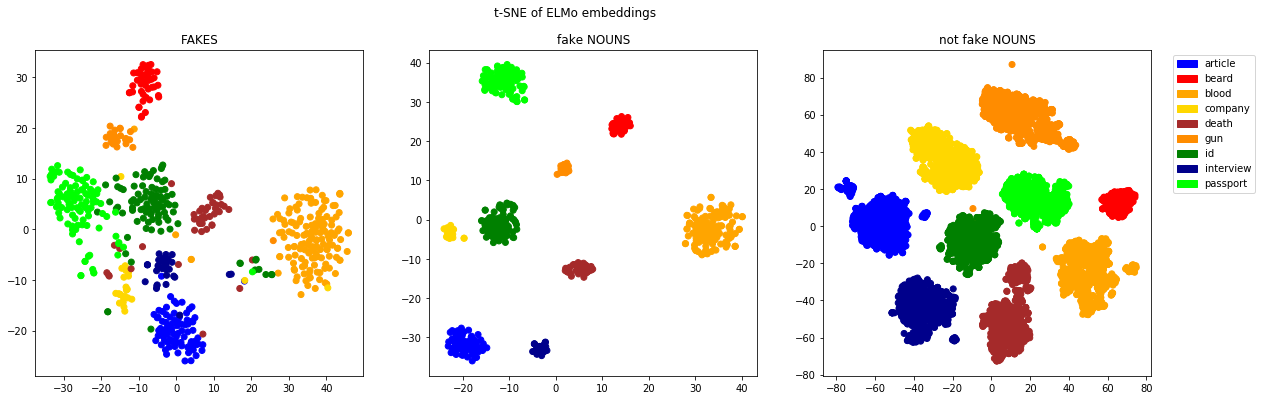

In [8]:
tsne = TSNE(n_components=2, init='pca', random_state=0)

colors={'article':'blue','beard':'red','blood':'orange','company':'gold','death':'brown','gun':'darkorange','id':'green','interview':'darkblue','passport':'lime'}

fig, ax = plt.subplots(1,3,figsize=(20,6)) #projection='3d'
for i, dataset in enumerate(datasets.keys()):
    trans_data = tsne.fit_transform(datasets[dataset][1]).T

    ax[i].scatter(trans_data[0], trans_data[1], color=datasets[dataset][-1].map(colors))
    ax[i].set_title(dataset)

handles = [mpatches.Patch(color=colors[n],label=n) for n in ('article','beard','blood','company','death','gun','id','interview','passport')]
plt.legend(handles = handles,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle("t-SNE of ELMo embeddings")
plt.axis('tight')
plt.savefig("TSNE_ELMo.png",dpi=300,bbox_inches = 'tight',pad_inches = 1)
plt.show()

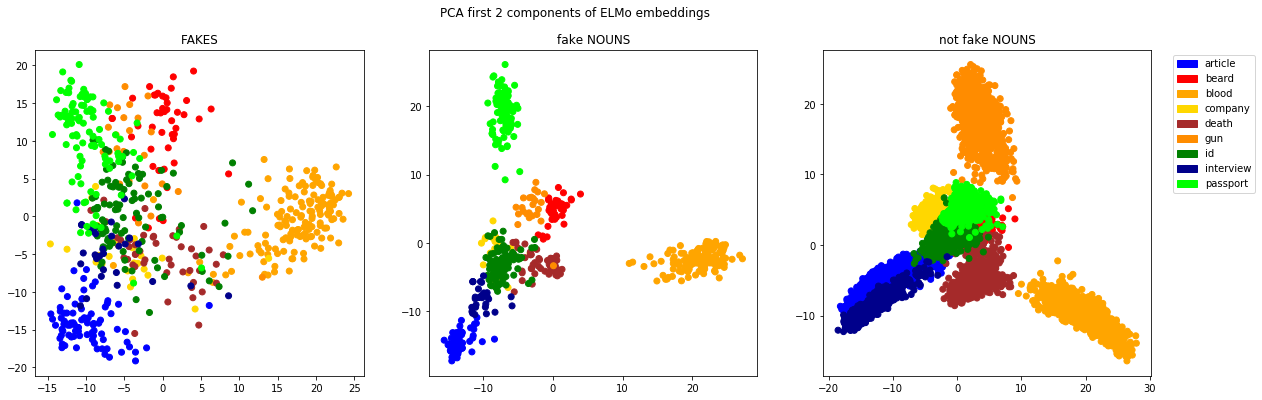

In [9]:
scaler = Scaler()
pca = PCA(n_components=2)

colors={'article':'blue','beard':'red','blood':'orange','company':'gold','death':'brown','gun':'darkorange','id':'green','interview':'darkblue','passport':'lime'}

fig, ax = plt.subplots(1,3,figsize=(20,6)) #projection='3d'
for i, dataset in enumerate(datasets.keys()):
    
    trans_data = pca.fit_transform( scaler.fit_transform(datasets[dataset][1]) ).T

    ax[i].scatter(trans_data[0], trans_data[1], color=datasets[dataset][-1].map(colors))
    ax[i].set_title(dataset)

handles = [mpatches.Patch(color=colors[n],label=n) for n in ('article','beard','blood','company','death','gun','id','interview','passport')]
plt.legend(handles = handles,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle("PCA first 2 components of ELMo embeddings")
plt.axis('tight')
plt.savefig("PCA_ELMo.png",dpi=300,bbox_inches = 'tight',pad_inches = 1)
plt.show()

In [6]:
def Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess=None,k=2,show_kbest=False):
    if preprocess=='pca':
        model = make_pipeline(Scaler(),PCA(n_components=0.975),classifier)
    else:
        model = classifier
    model.fit(Xtrain,Ttrain)
    y_train = model.predict(Xtrain)
    Tacc = np.sum(Ttrain == y_train)/len(Xtrain)
    y_banned = model.predict(Xbanned)
    Bacc = np.sum(Tbanned == y_banned)/len(Xbanned)
    return (Tacc,Bacc)

def BNC_accuracy(classifier,X,targets,nouns,preprocess=None,k=2,full_output=False,debug=False,show_kbest=False):
    if debug:
        print("\rTest {} : BNC  starting%                     ".format(debug), end="")
        sys.stdout.flush()
    Taccs = np.zeros(len(listNouns))
    Baccs = np.zeros(len(listNouns))
    
    for i,bannedW in enumerate(listNouns):
        if debug:
            print("\rTest {} : BNC for {} ; {}%             ".format(debug, bannedW, 100 * i // len(listNouns)), end="")
            sys.stdout.flush()
        Xtrain = X[nouns!=bannedW]
        Ttrain = targets[nouns!=bannedW]
        if preprocess=='kbest':
            select = SelectKBest(MIC,k).fit(Xtrain,Ttrain)
            scaler = Scaler()
            Xtrain = scaler.fit_transform(select.transform(Xtrain))
            if show_kbest:
                print("({})".format(np.where(select.get_support())[0]))
        Xbanned = X[nouns==bannedW]
        if preprocess == 'kbest':
            Xbanned = scaler.transform(select.transform(Xbanned))
        Tbanned = targets[nouns==bannedW]
        Tacc,Bacc = Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess,k,show_kbest)
        Taccs[i],Baccs[i] = Tacc, Bacc
    AvgTrain = np.mean(Taccs)
    AvgBanned = np.mean(Baccs)
    if full_output:
        return (Taccs,Baccs)
    else:
        return (AvgTrain,AvgBanned)

In [7]:
def find_best_BNC_model(dataset):
    warnings.filterwarnings('ignore') #ignore Warnings

    preprocesses = [None,'pca','tsne','kbest','kbest']
    models = ['Linear SVM', 'RBF SVM', 'Nearest Centroid']
    embds, X, targets, nouns = dataset
    kbest10 = False
    for i,preproc in enumerate(preprocesses):
        if preproc is None:
            print('-------------------- RAW DATA --------------------' )
        elif preproc == 'kbest':
            if kbest10:
                print('-------------------- {} (10) --------------------'.format(preproc) )
            else:
                print('-------------------- {} (2) --------------------'.format(preproc) )
        else:
            print('-------------------- {} --------------------'.format(preproc) )
        for j,model in enumerate(models):
            if model=='Linear SVM':
                clf = LinearSVC
                params = {'max_iter':100000}
            elif model=='RBF SVM':
                clf = SVC
                params = {'kernel':'rbf'}
            elif model == 'Nearest Centroid':
                clf = NearestCentroid
                params = dict()
            if preproc == 'kbest' and kbest10: #10-best 
                SBNC_train, SBNC_test = BNC_accuracy(clf(**params),X,targets,nouns,preprocess=preproc,k=10,debug=int(str(i+1)+str(j+1)))
            else: #all the rest
                SBNC_train, SBNC_test = BNC_accuracy(clf(**params),X,targets,nouns,preprocess=preproc,debug=int(str(i+1)+str(j+1)))
            
            print('\r{} ::   Train BNC : {}  Score BNC : {}'.format(model, np.round(SBNC_train,4), np.round(SBNC_test,4) ) )
            
        if preproc == 'kbest' and not kbest10:
            kbest10 = True
    warnings.filterwarnings('default')

# FAKE embeddings

In [13]:
find_best_BNC_model(datasets['FAKES'])

-------------------- RAW DATA --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.611
RBF SVM ::   Train BNC : 0.9949  Score BNC : 0.5805
Nearest Centroid ::   Train BNC : 0.8855  Score BNC : 0.6525
-------------------- pca --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.6361
RBF SVM ::   Train BNC : 0.999  Score BNC : 0.5914
Nearest Centroid ::   Train BNC : 0.8903  Score BNC : 0.6343
-------------------- tsne --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.611
RBF SVM ::   Train BNC : 0.9949  Score BNC : 0.5805
Nearest Centroid ::   Train BNC : 0.8855  Score BNC : 0.6525
-------------------- kbest (2) --------------------
Linear SVM ::   Train BNC : 0.9085  Score BNC : 0.7978
RBF SVM ::   Train BNC : 0.9092  Score BNC : 0.7898
Nearest Centroid ::   Train BNC : 0.9016  Score BNC : 0.8209
-------------------- kbest (10) --------------------
Linear SVM ::   Train BNC : 0.9563  Score BNC : 0.823
RBF SVM ::   Train BNC : 0.9651  Scor

In [14]:
find_best_BNC_model(datasets['fake NOUNS'])

-------------------- RAW DATA --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.6168
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.6494
Nearest Centroid ::   Train BNC : 0.9515  Score BNC : 0.5822
-------------------- pca --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.5662
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.5497
Nearest Centroid ::   Train BNC : 0.9584  Score BNC : 0.5543
-------------------- tsne --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.6168
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.6494
Nearest Centroid ::   Train BNC : 0.9515  Score BNC : 0.5822
-------------------- kbest (2) --------------------
Linear SVM ::   Train BNC : 0.9688  Score BNC : 0.9468
RBF SVM ::   Train BNC : 0.9702  Score BNC : 0.9489
Nearest Centroid ::   Train BNC : 0.9677  Score BNC : 0.9532
-------------------- kbest (10) --------------------
Linear SVM ::   Train BNC : 0.9928  Score BNC : 0.6262
RBF SVM ::   Train BNC : 0.9954  Score BNC

In [11]:
find_best_BNC_model(datasets['not fake NOUNS'])

-------------------- RAW DATA --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.7121
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.7533
Nearest Centroid ::   Train BNC : 0.9982  Score BNC : 0.646
-------------------- pca --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.7273
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.7488
Nearest Centroid ::   Train BNC : 0.9988  Score BNC : 0.6291
-------------------- tsne --------------------
Linear SVM ::   Train BNC : 1.0  Score BNC : 0.7121
RBF SVM ::   Train BNC : 1.0  Score BNC : 0.7533
Nearest Centroid ::   Train BNC : 0.9982  Score BNC : 0.646
-------------------- kbest (2) --------------------
Linear SVM ::   Train BNC : 0.9559  Score BNC : 0.7591
RBF SVM ::   Train BNC : 0.9573  Score BNC : 0.7453
Nearest Centroid ::   Train BNC : 0.9511  Score BNC : 0.7906
-------------------- kbest (10) --------------------
Linear SVM ::   Train BNC : 0.9938  Score BNC : 0.7869
RBF SVM ::   Train BNC : 0.9964  Score BNC :

In [9]:
warnings.filterwarnings('ignore')